## Haar Cascade Classifier Detecting Faces and Eyes

* Using pretrained haar cascade classifiers to detect faces and eyes in images and video streams;
* We use a sample image to experiment with the detection algorithm. Later, we use the webcam to capture an image to be classified;
* Real-time facial feature detection made possible using a video stream;
* Javascript code is utilized to capture pictures and the video stream from the webcam;
* **Code cells dependent on Javascript are functional only in Google's Colab. They can be made functional locally through the usage of libraries such as Js2Py, that allow Javascript execution in Python notebooks.**

In [1]:
from base64 import b64decode

import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js

## Model and Data Exploration

Function `imshow` is created so that we can easily plot images using Python's Matplotlib. We cannot use OpenCV's `imshow` since it causes crashes on Colab.

The function takes as argument a title for the image, the image itself and a size for it. The size argument refers to the height of the image. Width is automatically defined using the aspect ratio calculated using the original-sized image.

In [2]:
def imshow(title="Image", image=None, size=8):
    """Convert image to RGB format and plot it in a given size 
    maintaining the aspect ratio.

    Args:
        title (str, optional): Plot title. Defaults to "Image".
        image (numpy.ndarray, optional): Image to plot. Defaults to
            None.
        size (int, optional): Image height to use in plot, in inches.
    """
    h, w = image.shape[0], image.shape[1]
    aspect_ratio = w / h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

OpenCV provides pretrained haar cascade classifiers that usually perform very well. We can download them from the library's [repository at GitHub](https://github.com/opencv/opencv/tree/4.x/data/haarcascades). Anyway, they are also available at the "data" folder in the repository for this notebook.

There are many separate models for detecting faces and parts of faces. As we are focusing on face and eye detection, we load those particular models from their respective `.xml` files.

To instantiate one of these models we pass the model file to OpenCV's `CascadeClassifier` class constructor. Then, we can use the `detectMultiScale` method from the instantiated object to perform the detection. For performance reasons, we transform input images to grayscale before processing them.

We first load up a picture from Obama's face to experiment with the model.

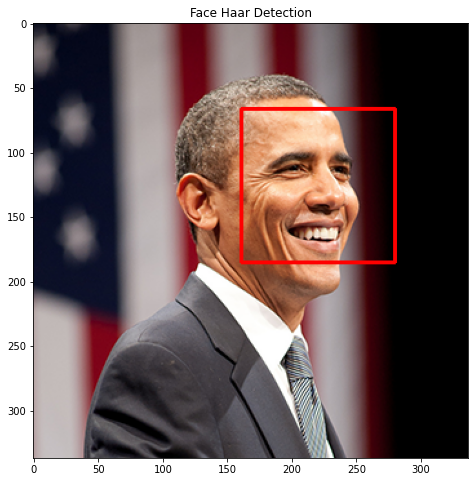

In [3]:
# Load pretrained haar cascade classifier for face detection.
haar_face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

image = cv2.imread('obama.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Smaller or larger scaleFactors/minNeighbors also work for face
# detection.
faces = haar_face_detector.detectMultiScale(gray, scaleFactor=1.3,
                                            minNeighbors=5)

if faces is ():
    print("No faces were found.")
else:
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    imshow("Face Haar Detection", image)

We can see that the rectangle drawn over Obama's face is precisely where his face is, even though his head is not in a front position to the camera. The more turned away from the camera is the face, the harder it is for a model to detect it.

Next, we load the eye detector model and use the image found by the face detector as input to the eye detector. Eyes are harder to detect than faces, therefore we use a smaller scale factor (1.02 versus 1.3 for face detection) to get less conservative detections. 

**Scale factor** regulates by how much the original image is going to be downscaled at each step of the image pyramid. This rescaling is performed because the models are trained using a specific image scaling. The algorithm iterates through a couple of rescaled images searching for detectable objects.

Meanwhile, we keep the **minimum number of neighbors** at 3, to avoid false positives around the eyes. This parameter forces every eye candidate portion of the image to have at least three neighboring portions belonging to eye regions.



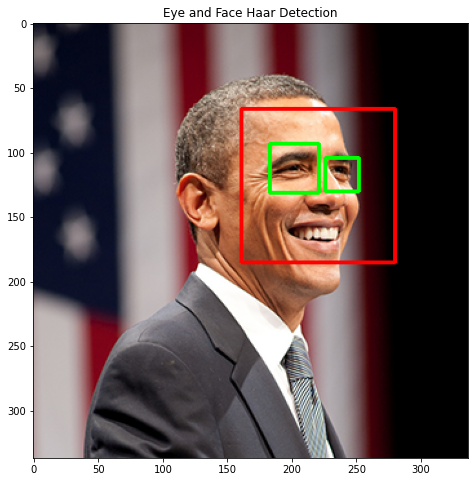

In [4]:
# Load pretrained haar cascade classifier for eye detection.
haar_eye_detector = cv2.CascadeClassifier('haarcascade_eye.xml')

image = cv2.imread('obama.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Smaller scale factor results in a smaller detection box, meaning that
# less data needs to be passed to the eye detector.
faces = haar_face_detector.detectMultiScale(gray, scaleFactor=1.3,
                                            minNeighbors=5)

if faces is ():
    print("No faces were found.")
else:
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        # Crop image with slicing. Eye detection on face region only.
        roi_color = image[y:y + h, x:x + w]
        roi_gray = gray[y:y + h, x:x + w]
        # Eye detector model needs a more sensitive scale factor.
        eyes = haar_eye_detector.detectMultiScale(roi_gray, scaleFactor=1.02,
                                                  minNeighbors=3)
        
        if eyes is ():
            print("No eyes were found.")
        else:
            for (eye_x, eye_y, eye_w, eye_h) in eyes:
                cv2.rectangle(roi_color, (eye_x, eye_y),
                              (eye_x + eye_w, eye_y + eye_h), (0, 255, 0), 2)
imshow("Eye and Face Haar Detection", image)

Obama's face and eyes are correcly detected in the image. Note how the rectangles around the eyes are of different size, that may be because the eyes were detected at different levels of scaling.

## Webcam Imagery Detection

`face_detector`, defined below, takes BGR images as input and finds faces and eyes in them.

Now, we use the same models to detect eyes and faces but on images captured by the webcam of the local computer. Once again, images are grayed out before being input to models. The parameters are set differently because the image resolution is different. The image cropping technique with Numpy slicing is also replicated.

In [ ]:
def face_detector(image):
    """Detect faces and eyes in images using haar cascade classifiers
    and draw rectangles over them.

    Args:
        image (numpy.ndarray): Image to perform detection and draw over.

    Returns:
        numpy.ndarray: Input image with rectangles drawn over facial
            features.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = haar_face_detector.detectMultiScale(gray, scaleFactor=1.8,
                                                minNeighbors=5)
    if faces is ():
        return image
    
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        roi_color = image[y:y + h, x:x + w]
        roi_gray = gray[y:y + h, x:x + w]
        eyes = haar_eye_detector.detectMultiScale(roi_gray, 1.1, 3)
        
        if eyes is ():
            return image
        else:
            for (eye_x, eye_y, eye_w, eye_h) in eyes:
                cv2.rectangle(roi_color, (eye_x, eye_y),
                            (eye_x + eye_w, eye_y + eye_h), (0, 255, 0), 2)
            
    return image

Since we are working with Google's Colab, we need to use Javascript to capture images from our local camera device and send it to the cloud. `take_pic` is the function we have for that. It takes a file name to give for the captured image and the desired quality to store it.

In Javascript, we create a `div` which has the video stream coming from the camera and a button to capture an image from the stream. Once the "Capture" button is clicked, the webcam resources are freed and the image is returned. We convert the image to base64 so that we can save it in a binary file.

In [ ]:
def take_pic(filename='pic.jpg', quality=0.8):
    """Use Javascript code to get a frame from the local computer's
    webcam once the "Capture" button is pressed. Bring the frame to
    Colab and save it as a binary base64 file.

    Args:
        filename (str, optional): Name of the file to save frame into.
            Defaults to "pic.jpg".
        quality (float, optional): Image quality to transmit the frame
            to Colab. Defaults to 0.8.

    Returns:
        str: Name of the file used to save the frame.
    """
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({
                video: true
            });

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize output to fit video element.
            google.colab.output.setIframeHeight(
                document.documentElement.scrollHeight, true
            );

            // Wait for capture click.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    # Displays Javascript-based interface in notebook.
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

<IPython.core.display.Javascript object>

Saved picture as: pic.jpg


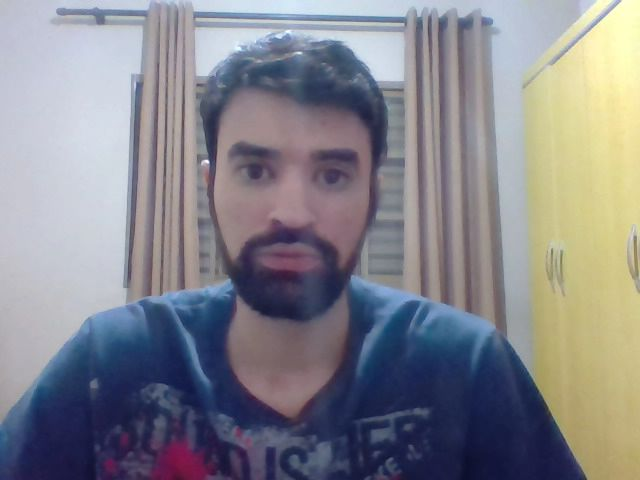

In [ ]:
try:
    filename = take_pic()
    print('Saved picture as:', filename)
    display(Image(filename))
except Exception as err:
    print(str(err))

With the image's file name in our hands, all we have to do is load it and send it to `face_detector`. Later, we pass the returned image, with the rectangles drawn over the facial features, directly to the `imshow` function.

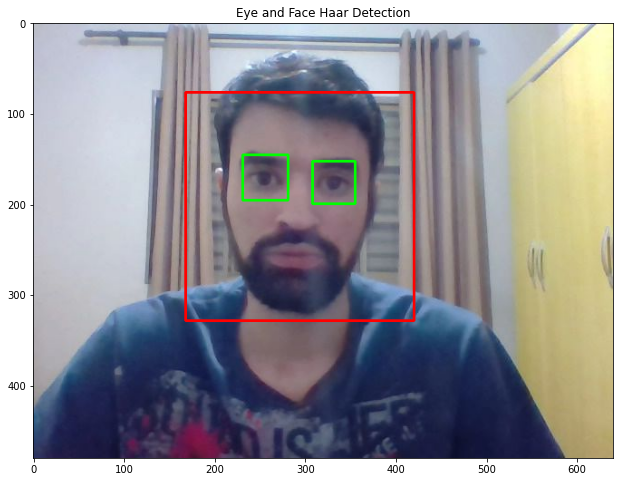

In [ ]:
image = cv2.imread(filename)
imshow("Eye and Face Haar Detection", face_detector(image))

For last, we create two new functions that help to perform facial feature detection directly on the video stream. `json_to_image` just converts a JSON object to an OpenCV BGR image. `video_stream` performs mostly like the previous `take_pic` function, but now there is no "Capture" button. This time, a constant video stream is captured from the webcam and the images are constantly passed to `face_detector`.

There is a "Click here to stop the video" button that, once pressed, closes the video stream. Resources are then freed and no frame is returned. With no frames to evaluate, the while loop ends and just the last frame evaluated is kept on display.

We reduce image resolution to 640x480 to increase the overall speed of the method. However, even in lower resolutions the processing is laggy on Colab's standard machine. Each frame takes approximately 1.1 seconds to be captured, evaluated and displayed.

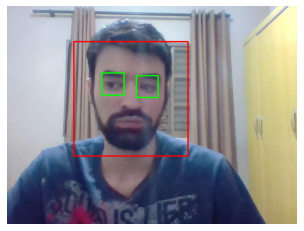

In [ ]:
def json_to_image(js_object):
    """Converts JSON object to OpenCV BGR image.

    Args:
        js_object(str): JSON object to convert to OpenCV BGR image.

    Returns:
        numpy.ndarray: OpenCV BGR image.
    """
    image_bytes = b64decode(js_object.split(',')[1])
    # Bytes to Numpy array.
    img_array = np.frombuffer(image_bytes, dtype=np.uint8)
    # Numpy array to OpenCV BGR.
    frame = cv2.imdecode(img_array, flags=1)

    return frame

def video_stream():
    """Use Javascript code to open a video stream using the local
    computer's webcam. Transmit the captured frames to Colab until a
    button is pressed to end the stream.
    """
    js = Javascript('''
        let video;
        let div = null;
        let stream;
        let captureCanvas;
        let imgElement;
        
        let pendingResolve = null;
        let shutdown = false;
        
        // Free resources once video stream stops.
        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
        }
        
        // Draw every frame on Colab until the stream stops.
        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                let result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }
                let lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }
        
        // Create div to hold video stream and button.
        async function createDom() {
            if (div !== null) {
                return stream;
            }
            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);
                
            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                {video: { facingMode: "environment"}});
            div.appendChild(video);
            
            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);
            
            const instruction = document.createElement('div');
            instruction.innerHTML = 
                '<span style="blue: red; font-weight: bold;">' +
                'click here to stop the video</span>';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };
            
            video.srcObject = stream;
            await video.play();
            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640; 
            captureCanvas.height = 480; 
            window.requestAnimationFrame(onAnimationFrame);
            
            return stream;
        }

        // Function to manage the whole Javascript code.
        async function stream_frame() {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }
            
            stream = await createDom();
                                
            let result = await new Promise(function(resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;
            
            return result
        }
    ''')

    # Displays Javascript-based interface in notebook.
    display(js)

# Start webcam stream.
video_stream()

# While the stream is not closed, perform detection.
while True:
    clear_output(wait=True)
    frame_js = eval_js('stream_frame()')
    if not frame_js:
        break
    img = json_to_image(frame_js)
    plt.imshow(cv2.cvtColor(face_detector(img), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

The models work fine and they rarely give false positives. Nonetheless, if the face is turned or too far away from the camera, they fail to detect facial features. It is also important to consider that facial feature detection models usually have a hard time detecting features on bearded faces, given a lack of training samples having that feature.

Lower resolutions may increase speed performance but will also make it harder for the model to work. Making the haar models have less resource-demanding parameters (scale factor set higher and mininum neighborhood set lower) does not help much, so we tuned them for better accuracy.